In [313]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
import pandas as pd
# import necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
optimizer = Adam(learning_rate=0.01)
lossFunct = SparseCategoricalCrossentropy()

In [314]:
# # For Colab
# !wget http://www.kasprowski.pl/datasets/adversarial/signs_model.h5
# !wget http://www.kasprowski.pl/datasets/adversarial/signs_labels.csv
# !wget http://www.kasprowski.pl/datasets/adversarial/stop.jpg

In [315]:
model = tf.keras.models.load_model("signs_model.h5")

In [316]:
image_name = 'Stop sign'
image = cv2.imread("stop.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (64,64))
baseImage = tf.constant(image, dtype=tf.float32)
print(baseImage.shape)
print("Image",image_name,"loaded")

(64, 64, 3)
Image Stop sign loaded


In [317]:

classes = pd.read_csv('signs_labels.csv')
for i in range(20):
    print(f'Label {i}: {classes.loc[i][1]}')

Label 0: Speed limit (20km/h)
Label 1: Speed limit (30km/h)
Label 2: Speed limit (50km/h)
Label 3: Speed limit (60km/h)
Label 4: Speed limit (70km/h)
Label 5: Speed limit (80km/h)
Label 6: End of speed limit (80km/h)
Label 7: Speed limit (100km/h)
Label 8: Speed limit (120km/h)
Label 9: No passing
Label 10: No passing for vehicles over 3.5 metric tons
Label 11: Right-of-way at the next intersection
Label 12: Priority road
Label 13: Yield
Label 14: Stop
Label 15: No vehicles
Label 16: Vehicles over 3.5 metric tons prohibited
Label 17: No entry
Label 18: General caution
Label 19: Dangerous curve to the left


1/1 [==============================] - 0s 113ms/step
Image classified as class 14, Stop with probalility 0.9609633088111877


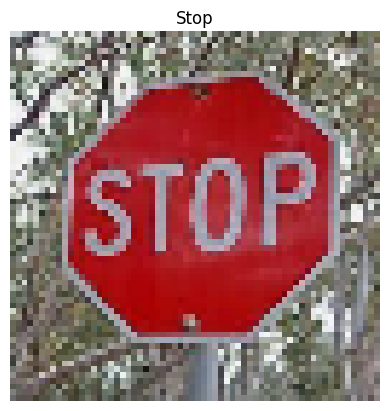

In [318]:
# add one dimension
image2 = np.expand_dims(baseImage, axis=0)
# predict
pred = model.predict(image2)
max = pred[0].argmax()
real_pred = pred
real_max = max
plt.imshow(image)
plt.title(classes.loc[max][1])
plt.axis("off")
print(f'Image classified as class {max}, {classes.loc[max][1]} with probalility {pred[0][max]}')

In [319]:
def do_step(image,delta,real_class):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        adversary = (baseImage + delta)
        predictions = model(adversary, training=False)

#         originalLoss = lossFunct(tf.convert_to_tensor([real_class]),predictions)
#         loss = - originalLoss

        originalLoss = lossFunct(tf.convert_to_tensor([real_class]),predictions)
        targetLoss = lossFunct(tf.convert_to_tensor([target_class]),predictions)
        loss = targetLoss - originalLoss  # goal: minimize error to targetLoss and maximize error to originalLoss


    gradients = tape.gradient(loss, delta)

#     optimizer.apply_gradients([(gradients, delta)])
#     delta.assign_add(delta)

    optimizer.apply_gradients([(gradients, delta)])
    clipped_delta = tf.clip_by_value(delta, clip_value_min=-0.01, clip_value_max=0.01)
    delta.assign_add(clipped_delta)


    return delta,loss

In [320]:
def show_step(delta,loss):
    print("step: {}, loss: {}...".format(step, loss.numpy()))
    adverImage = (baseImage + delta).numpy().squeeze()
    adverImage = np.clip(adverImage, 0, 255).astype("uint8")
    adverImage = np.expand_dims(adverImage, axis=0)

    prediction = model.predict((adverImage))
    top = prediction[0].argmax()
    # predictions = model.predict(tf.keras.applications.resnet50.preprocess_input(adverImage))
    # top3 = decode_predictions(predictions, top=3)[0]
    # print("{}. {} -> ({}:{:.2f}, {}:{:.2f}, {}:{:.2f})".format(step,max,
    #             top3[0][1],top3[0][2],
    #             top3[1][1],top3[1][2],
    #             top3[2][1],top3[2][2]))

    fig=plt.figure(figsize=(12,8))
    ax = plt.subplot(1, 3, 1)
    plt.title(f"Original {real_max}:{100*pred[0][real_max]:.2f}%")
    plt.imshow(image.squeeze())
    plt.axis("off")
    ax = plt.subplot(1, 3, 2)
    plt.title("Delta")
    plt.imshow(np.clip((delta.numpy().squeeze()*256).astype("uint8"), 0, 255))
    plt.axis("off")
    ax = plt.subplot(1, 3, 3)
    plt.title(f"Adversary {classes.loc[top][1]} {top}:{100*prediction[0][top]:.2f}%")
    plt.imshow(adverImage.squeeze())
    plt.axis("off")
    plt.show()
    cv2.imwrite(f"outdir/{image_name}_{step:02d}.jpg", cv2.cvtColor(adverImage.squeeze(), cv2.COLOR_RGB2BGR))


    if(100*prediction[0][top] == 100 and top == 12):
      breakLoop = True
    else:
      breakLoop = False

    return breakLoop

step: 0, loss: 41.862693786621094...
1/1 [==============================] - 0s 104ms/step


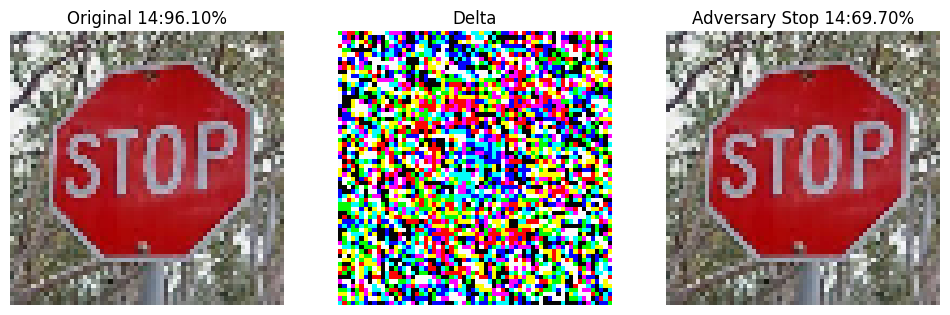

step: 50, loss: 33.44057083129883...
1/1 [==============================] - 0s 33ms/step


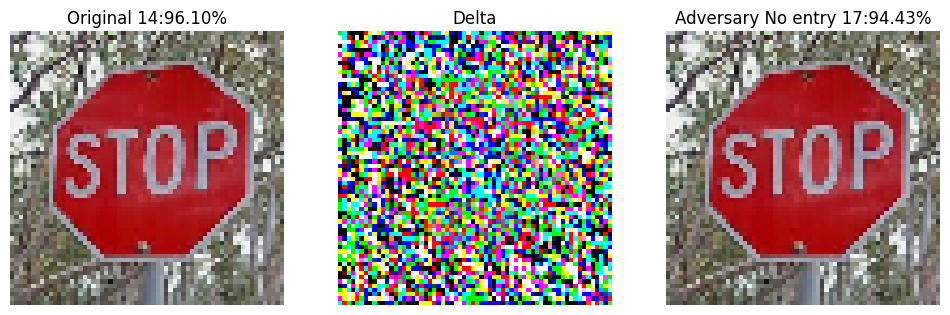

step: 100, loss: 25.632015228271484...
1/1 [==============================] - 0s 25ms/step


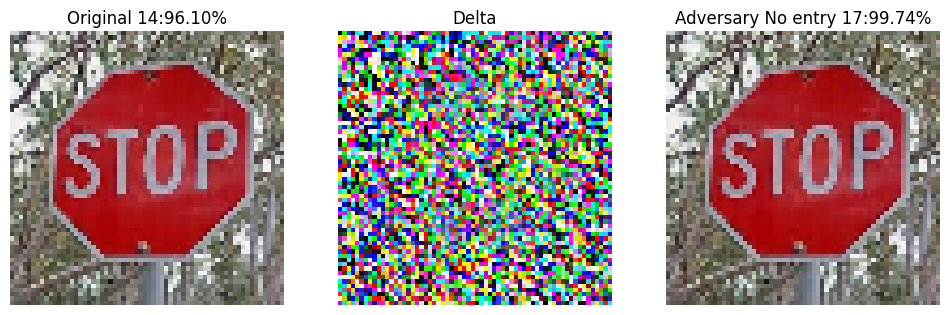

step: 150, loss: 18.190773010253906...
1/1 [==============================] - 0s 23ms/step


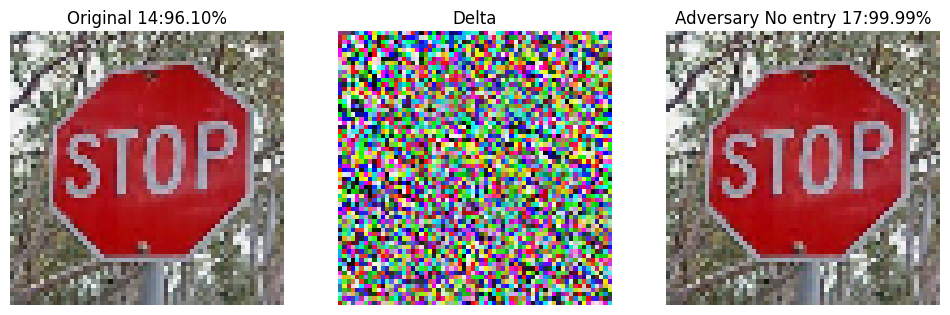

step: 200, loss: 11.277382850646973...
1/1 [==============================] - 0s 24ms/step


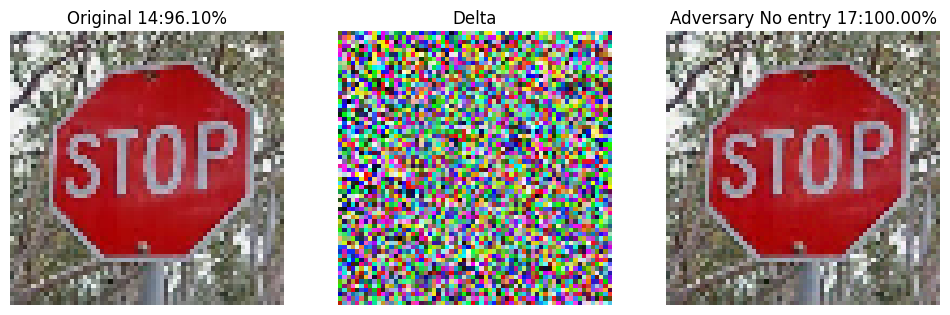

step: 250, loss: 4.77311897277832...
1/1 [==============================] - 0s 23ms/step


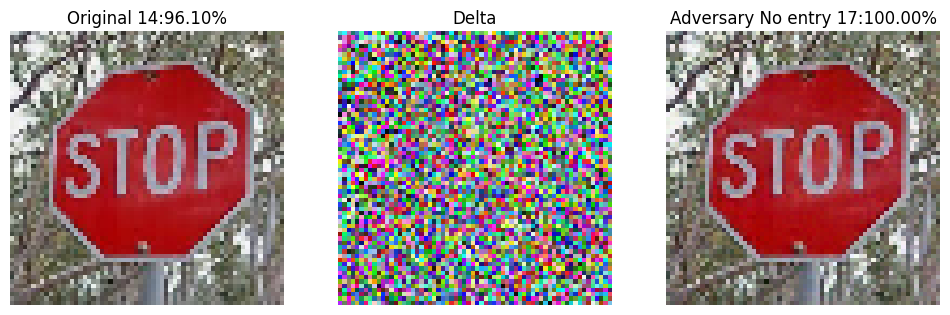

step: 300, loss: -1.4839763641357422...
1/1 [==============================] - 0s 24ms/step


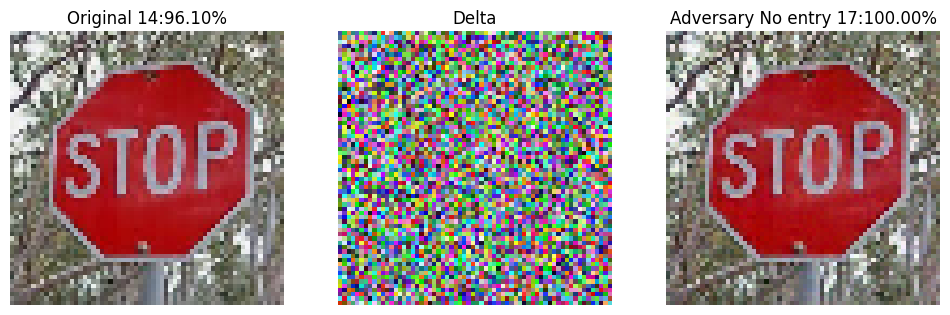

step: 350, loss: -7.667131423950195...
1/1 [==============================] - 0s 36ms/step


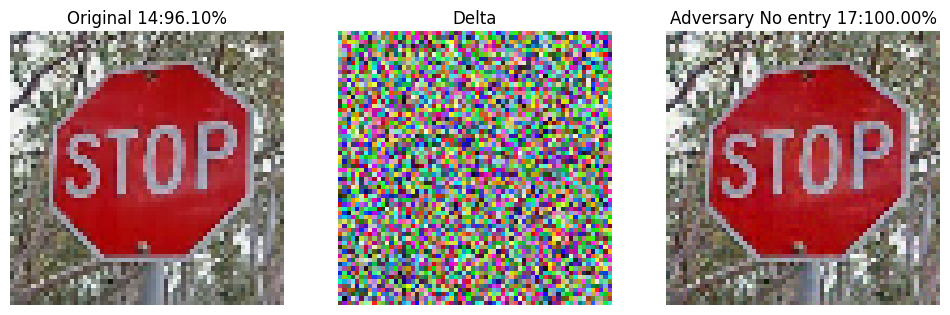

step: 400, loss: -13.80199909210205...
1/1 [==============================] - 0s 24ms/step


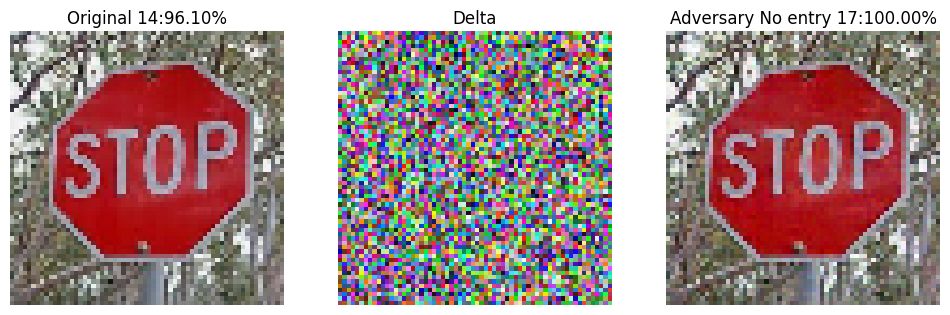

step: 450, loss: -19.902250289916992...
1/1 [==============================] - 0s 23ms/step


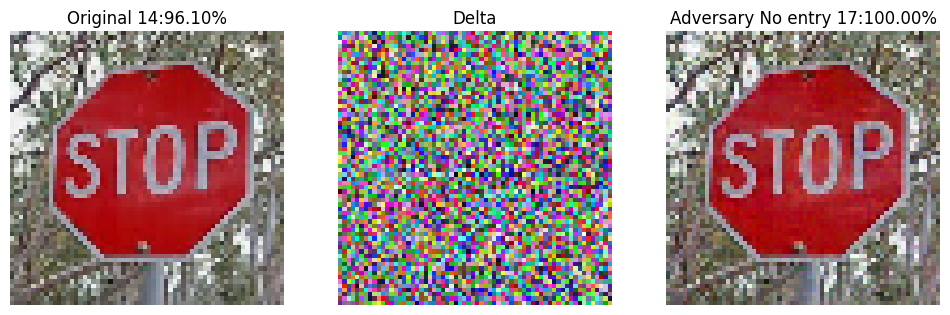

step: 500, loss: -25.83211898803711...
1/1 [==============================] - 0s 22ms/step


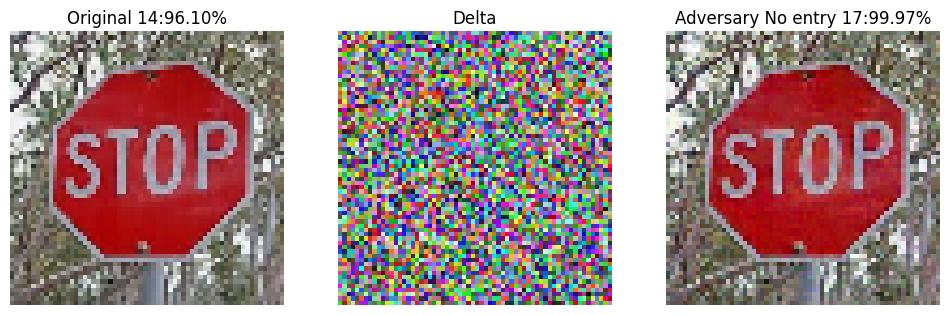

step: 550, loss: -31.708393096923828...
1/1 [==============================] - 0s 23ms/step


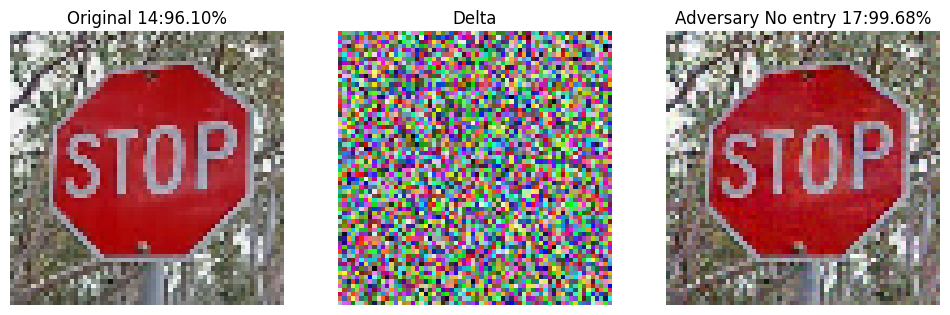

step: 600, loss: -37.446556091308594...
1/1 [==============================] - 0s 32ms/step


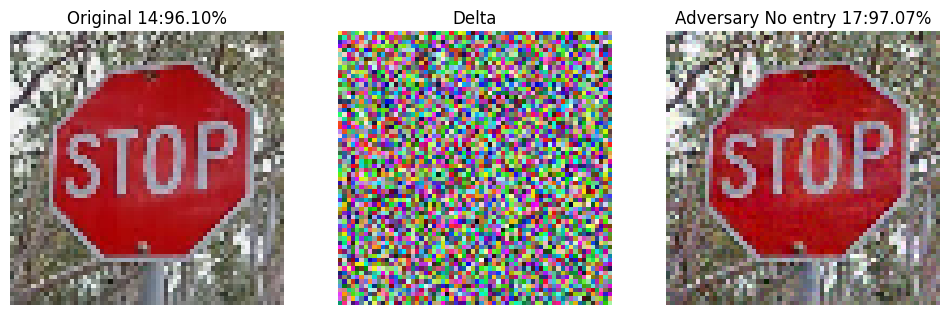

step: 650, loss: -43.04690170288086...
1/1 [==============================] - 0s 24ms/step


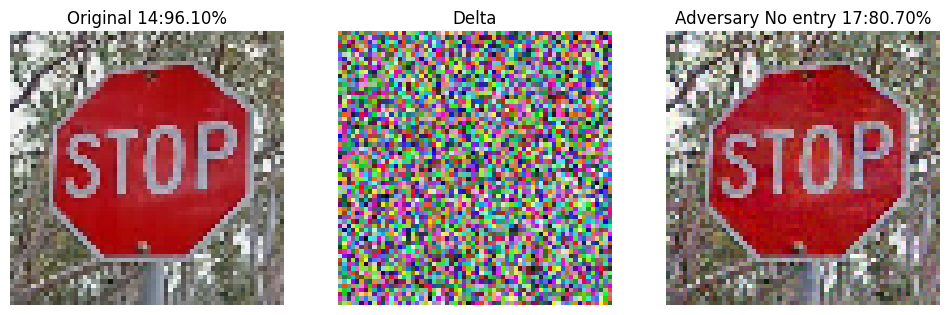

step: 700, loss: -48.26095199584961...
1/1 [==============================] - 0s 23ms/step


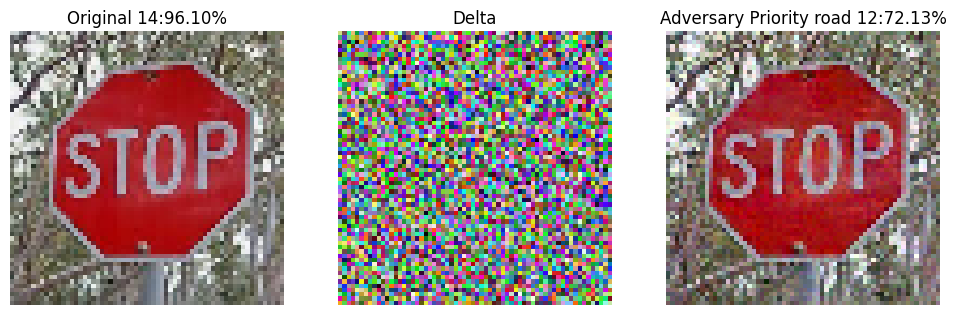

step: 750, loss: -53.33707809448242...
1/1 [==============================] - 0s 23ms/step


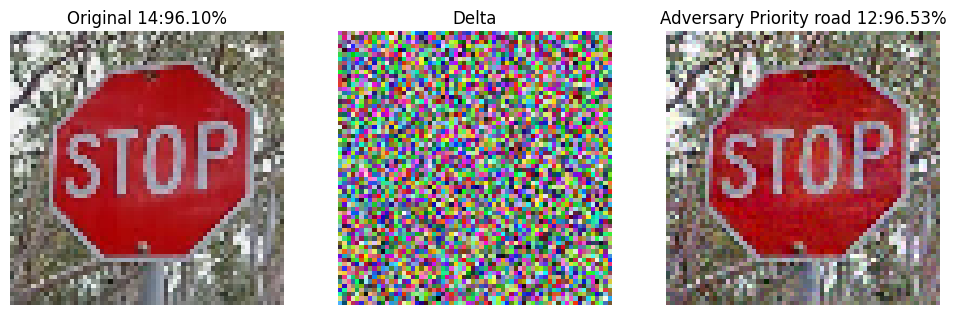

step: 800, loss: -58.382484436035156...
1/1 [==============================] - 0s 28ms/step


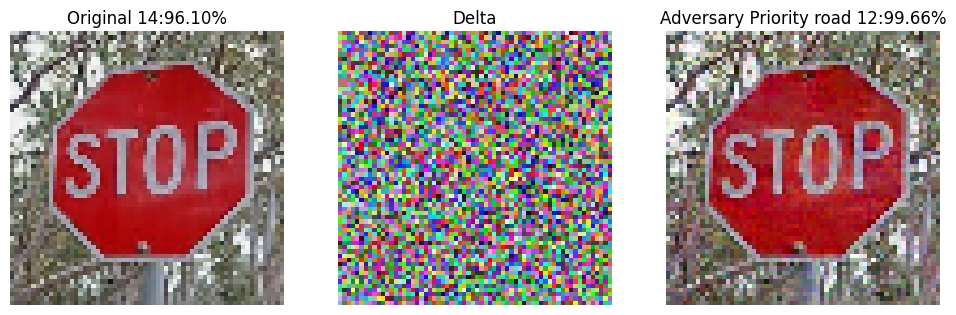

step: 850, loss: -63.361995697021484...
1/1 [==============================] - 0s 24ms/step


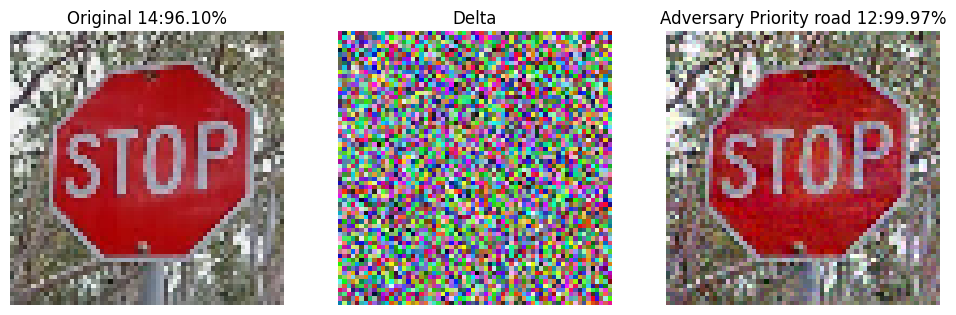

step: 900, loss: -68.28780364990234...
1/1 [==============================] - 0s 41ms/step


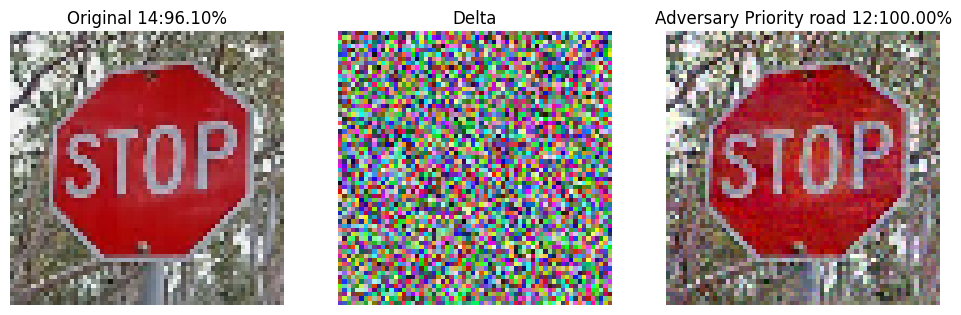

step: 950, loss: -73.14594268798828...
1/1 [==============================] - 0s 26ms/step


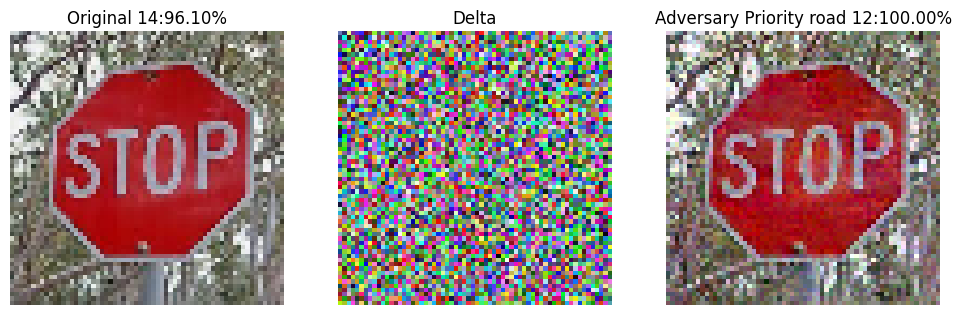

Done


In [321]:
breakLoop = False
steps = 1000
target_class = 12
delta = tf.Variable(tf.zeros_like(image2), trainable=True)
for step in range(0, steps):
    delta,loss = do_step(image2, delta, max)
    if step % 50==0:
        breakLoop=show_step(delta,loss)
        if breakLoop == True:
          break
print("Done")